# Capstone Project - The Battle of the Neighborhoods

#### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [1. Introduction: Business Problem](#introduction)
* [2. Data](#data)
* [3. Methodology and Analysis](#methodology)
* [4. Results and Discussion](#results)
* [5. Conclusion](#conclusion)

# 1. Introduction: Business Problem <a id='introduction'></a>

#### Toronto vs York. Where to eat better?

Eventually, at some point in life, we must leave behind the place we have lived in for years, for a job change, looking for better opportunities, or simply to gain new experiences.

There are many elements that we must consider in order to make a decision about the place we will choose to live the next stage of our life. Since, in general, people change their home to live there for a long time, the resources available in the new home must be analyzed in depth, since the quality of life, that they have, will largely depend on it.

One of the points that must be taken into account is food, so in this analysis we will focus on distinguishing which city has the best places to eat. The cities considered are those that contain the words Toronto (Downtown Toronto, East Toronto, West Toronto, Central Toronto) and York (North York, East York, York), we will treat each group as a different city.

# 2. Data

We will use the data provided by Wikipedia to obtain the postal code of each city mentioned, we will unify the cities to have only two at the end (Toronto and York).

We will use the latitude and longitude data to print each location on a map.

Then we will use the Foursquare API to obtain the ratings of the restaurant category to finally obtain an average rating for each city and thus be able to select the best one.

### Import the libraries that we will use.

In [1]:
import pandas as pd
from pandas.io.json import json_normalize

import numpy as np

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import requests

from geopy.geocoders import Nominatim
import folium

import seaborn as sns

import time

### Create the request which will get the HTML document than contains the data.

In [2]:
req = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(req.text,'html.parser')

### Whit the data in the soup object, we will scrape the HTML document that contains until to get de table element. Then we will iterate in it to get each row and append each in a pandas DataFrame.

In [36]:
# Get table element
table = soup.find('table')

# Get headers of table
col_names = table.find_all('th')
names = []
for name in col_names:
    names.append(name.string.strip()) 

# Create the DataFrame which will contain the data
df = pd.DataFrame(columns = names)

# Append each row in the DataFrame
data = table.tbody.find_all('tr')
for reg in data:
    row = [ x.string.strip() for x in reg.find_all('td') ]
    if len(row) > 0:
        df = df.append( pd.DataFrame([row],columns =df.columns), ignore_index=True)

print(df.shape)
df.head(10)

(180, 3)


,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


### Clean and check data.

In [4]:
# Clean dataframe

# Ignore cells with a borough that is Not assigned.
df = df[(df['Borough'] != 'Not assigned')]
print('Not assigned borough =',df[(df['Borough'] == 'Not assigned')]['Borough'].count())

# More than one neighborhood can exist in one postal code area.
print('Repeated postal code areas =',df['Postal Code'].value_counts()[(df['Postal Code'].value_counts() > 1)].count() )

# Not assigned neighborhood count.
print('Not assigned neighborhood =',df[(df['Neighbourhood'] == 'Not assigned')]['Neighbourhood'].count())

df.reset_index(drop = True, inplace = True)

df.head()

Not assigned borough = 0
Repeated postal code areas = 0
Not assigned neighborhood = 0


,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [5]:
df.shape

(103, 3)

### Get the latitude and the longitude coordinates of each neighborhood.

In [38]:
df_cp = pd.read_csv('..\..\Datasets\Geospatial_Coordinates.csv')
df_cp.head(5)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
data = pd.merge(df, df_cp, on = "Postal Code")
data.rename(columns={'Postal Code':'PostalCode','Neighbourhood':'Neighborhood'}, inplace = True)
data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [8]:
data['Borough'].unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

In [9]:
Toronto_mask = (data['Borough'] == 'Downtown Toronto') | (data['Borough'] == 'East Toronto') | (data['Borough'] == 'West Toronto') | (data['Borough'] == 'Central Toronto') 

York_mask = (data['Borough'] == 'North York') | (data['Borough'] == 'East York') | (data['Borough'] == 'York')

In [10]:
Toronto_data = data[Toronto_mask]
Toronto_data.reset_index(drop = True, inplace = True)
Toronto_data['Borough'] = 'Toronto'
print(Toronto_data.shape)
Toronto_data.head()

(39, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Toronto,St. James Town,43.651494,-79.375418
4,M4E,Toronto,The Beaches,43.676357,-79.293031


In [11]:
York_data = data[York_mask]
York_data.reset_index(drop = True, inplace = True)
York_data['Borough'] = 'York'
print(York_data.shape)
York_data.head()

(34, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,York,Parkwoods,43.753259,-79.329656
1,M4A,York,Victoria Village,43.725882,-79.315572
2,M6A,York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
3,M3B,York,Don Mills,43.745906,-79.352188
4,M4B,York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937


### In this cell we will obtain the complete dataset with the Latitude and Longitude values for each Neighborhood.

In [12]:
data = Toronto_data.append(York_data, ignore_index=True)
data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Toronto,St. James Town,43.651494,-79.375418
4,M4E,Toronto,The Beaches,43.676357,-79.293031
...,...,...,...,...,...
68,M3N,York,Downsview,43.761631,-79.520999
69,M6N,York,"Runnymede, The Junction North",43.673185,-79.487262
70,M9N,York,Weston,43.706876,-79.518188
71,M2P,York,York Mills West,43.752758,-79.400049


# 3. Methodology and Analysis

## The methodology to follow consist in get restaurants data of Toronto and York from Foursquare API. We will use standard and premium calls to get that information for each restaurant. We will clean and analyze those data to get insights and then put into a Kmeans algorithm to generate clusters and get conclusion. We will support od Folium library too to create visual material and make the analysis more interactive.

We will coment the analysis along the notebook.

## Define functions that we will to use to make the analysis.

### Define a function to populate with markers the map with Toronto and York data.

In [13]:
def addMakers(data,map_obj,color):
    for lat, lng, borough, neighborhood in zip(data['Latitude'], data['Longitude'], data['Borough'], data['Neighborhood']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=7,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=1,
            parse_html=False).add_to(map_obj) 

### Define a function that extracts the category of the venue, to use in next section.

In [14]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Function to create the API request URL, make the GET request and return the relevant information for each nearby venue in Toronto and York.

In [15]:
def getNearbyVenues(data, radius=500):
    
    venues_list=[]

    boroughs = data['Borough']
    names = data['Neighborhood']
    latitudes = data['Latitude']
    longitudes = data['Longitude']

    for borough, name, lat, lng in zip(boroughs, names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng,
            v['venue']['id'],  
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue ID', 
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Function that append the venues ratings in an array.

In [16]:
def getRatingVenue(data):
    
    ratings_list=[]
    for venueId, name in zip(data['Venue ID'], data['Venue Name']):
        #print(name)

        VENUE_ID = venueId  
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            VENUE_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['venue']

            # return only relevant information for each nearby venue
            ratings_list.append([ (venueId,name,results['rating']) ])
        except:
            ratings_list.append([ (venueId,name,np.nan) ])

    ratings_venues = pd.DataFrame([item for rating in ratings_list for item in rating])
    ratings_venues.columns = [['Venue ID','Venue Name','Venue Rating']]
    time.sleep(.5)
    return(ratings_venues)

### Define a function to populate with markers the map with Toronto and York data with fill.

In [17]:
def addMakersFilled(data,map_obj,color):
    for lat, lng, borough, neighborhood, c_label in zip(data['Neighborhood Latitude'], data['Neighborhood Longitude'], data['Borough'], data['Neighborhood'], data['Cluster Labels']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        fill = 'green' if c_label == 1 else 'red'
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            popup=label,
            color=color,
            fill=True,
            fill_color=fill,
            fill_opacity=0.5,
            parse_html=False).add_to(map_obj) 

### Get coordinates of Toronto and York, then create a map with Folium.

In [18]:
# Get coordinates of Toronto
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
T_latitude = location.latitude
T_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(T_latitude, T_longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [19]:
# Get coordinates of York
address = 'York, Canada'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
Y_latitude = location.latitude
Y_longitude = location.longitude
print('The geograpical coordinate of York are {}, {}.'.format(Y_latitude, Y_longitude))

The geograpical coordinate of York are 43.6896191, -79.479188.


In [20]:
latitude = np.mean([T_latitude,Y_latitude])
longitude = np.mean([T_longitude,Y_longitude])

### Create the map.

In [21]:
map_ty = folium.Map(location=[latitude, longitude], zoom_start=12)

addMakers(data[data['Borough']=='Toronto'],map_ty,'blue')
addMakers(data[data['Borough']=='York'],map_ty,'orange')
map_ty

### We can see than the map is more populated with Toronto (blue) venues than York (orange).

### Define Foursquare Credentials and Version.

In [22]:
CLIENT_ID = 'J4OZD0YVDTOFSEOA0YMG3JNX1Q5FSHJ1XFGV4Y5DGETWDVDC' # your Foursquare ID
CLIENT_SECRET = 'L0LLLYBWKOIIUCL2WVHLI4KFEVK4CVETPT003JMSG51FJIMM' # your Foursquare Secret
VERSION = '20200601' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: J4OZD0YVDTOFSEOA0YMG3JNX1Q5FSHJ1XFGV4Y5DGETWDVDC
CLIENT_SECRET:L0LLLYBWKOIIUCL2WVHLI4KFEVK4CVETPT003JMSG51FJIMM


### We will use getNearbyVenues function to get the venues of Toronto and York.

In [39]:
data_venues = getNearbyVenues(data)
data_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,5612b1cc498e3dd742af0dc8,Impact Kitchen,43.656369,-79.356980,Restaurant
1,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,53a22c92498ec91fda7ce133,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
2,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,51ddecee498e1ffd34185d2f,El Catrin,43.650601,-79.358920,Mexican Restaurant
3,Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4a8355bff964a520d3fa1fe3,Mercatto,43.660391,-79.387664,Italian Restaurant
4,Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,52d884c5498ecf5c7cafe5ab,Nando's,43.661728,-79.386391,Portuguese Restaurant
...,...,...,...,...,...,...,...,...,...
443,York,"Willowdale, Willowdale East",43.770120,-79.408493,4bb628fbef159c74e18075f7,Shawarma Max,43.766012,-79.410844,Middle Eastern Restaurant
444,York,"Willowdale, Willowdale East",43.770120,-79.408493,544ad69a498eeb86b7a4a8d0,Kinton Ramen,43.769684,-79.413049,Ramen Restaurant
445,York,"Willowdale, Willowdale East",43.770120,-79.408493,4b4779f0f964a520543326e3,Pho 88 Vietnamese Cuisine,43.770456,-79.413064,Vietnamese Restaurant
446,York,"Willowdale, Willowdale East",43.770120,-79.408493,4b8bffc6f964a52076b732e3,Ichiban Fish House,43.765995,-79.410813,Japanese Restaurant


### Then, only get the Restaurant category from the data.

In [40]:
data_venues = data_venues[data_venues['Venue Category'].str.contains("Restaurant")]
data_venues.reset_index(drop = True, inplace = True)
print(data_venues.shape)
data_venues

(448, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,5612b1cc498e3dd742af0dc8,Impact Kitchen,43.656369,-79.356980,Restaurant
1,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,53a22c92498ec91fda7ce133,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
2,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,51ddecee498e1ffd34185d2f,El Catrin,43.650601,-79.358920,Mexican Restaurant
3,Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4a8355bff964a520d3fa1fe3,Mercatto,43.660391,-79.387664,Italian Restaurant
4,Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,52d884c5498ecf5c7cafe5ab,Nando's,43.661728,-79.386391,Portuguese Restaurant
...,...,...,...,...,...,...,...,...,...
443,York,"Willowdale, Willowdale East",43.770120,-79.408493,4bb628fbef159c74e18075f7,Shawarma Max,43.766012,-79.410844,Middle Eastern Restaurant
444,York,"Willowdale, Willowdale East",43.770120,-79.408493,544ad69a498eeb86b7a4a8d0,Kinton Ramen,43.769684,-79.413049,Ramen Restaurant
445,York,"Willowdale, Willowdale East",43.770120,-79.408493,4b4779f0f964a520543326e3,Pho 88 Vietnamese Cuisine,43.770456,-79.413064,Vietnamese Restaurant
446,York,"Willowdale, Willowdale East",43.770120,-79.408493,4b8bffc6f964a52076b732e3,Ichiban Fish House,43.765995,-79.410813,Japanese Restaurant


### Use the getRatingVenue function to get the rating for each restaurant in the dataset. This function uses a Premium call of Foursquare.

In [25]:
path_ratings = 'D:\\Repositorios\\Coursera\\Coursera_Capstone\\Notebooks\\Final Report\\data_ratings.csv'

#data_ratings = getRatingVenue(data_venues)
#data_ratings.to_csv(path_ratings ,index=False)

data_ratings = pd.read_csv(path_ratings)
print(data_ratings.shape)

data_ratings.head()

(449, 3)


,Venue ID,Venue Name,Venue Rating
0,5612b1cc498e3dd742af0dc8,Impact Kitchen,8.8
1,53a22c92498ec91fda7ce133,Cluny Bistro & Boulangerie,8.3
2,51ddecee498e1ffd34185d2f,El Catrin,7.9
3,4a8355bff964a520d3fa1fe3,Mercatto,8.3
4,52d884c5498ecf5c7cafe5ab,Nando's,8.1


### Merge Toronto and York venues data with its ratings and drop instances with null values.

In [26]:
data_merge = pd.merge(data_venues,data_ratings.drop('Venue Name',axis=1), on='Venue ID')
data_merge.drop_duplicates(inplace = True)
data_merge.dropna(inplace=True)
data_merge.reset_index(drop = True, inplace = True)

data_merge

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category,Venue Rating
0,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,5612b1cc498e3dd742af0dc8,Impact Kitchen,43.656369,-79.356980,Restaurant,8.8
1,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,53a22c92498ec91fda7ce133,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant,8.3
2,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,51ddecee498e1ffd34185d2f,El Catrin,43.650601,-79.358920,Mexican Restaurant,7.9
3,Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4a8355bff964a520d3fa1fe3,Mercatto,43.660391,-79.387664,Italian Restaurant,8.3
4,Toronto,Central Bay Street,43.657952,-79.387383,4a8355bff964a520d3fa1fe3,Mercatto,43.660391,-79.387664,Italian Restaurant,8.3
...,...,...,...,...,...,...,...,...,...,...
425,York,"Willowdale, Willowdale East",43.770120,-79.408493,4b832e14f964a5200dfc30e3,Wendy’s,43.768461,-79.412377,Fast Food Restaurant,6.2
426,York,"Willowdale, Willowdale East",43.770120,-79.408493,4bb628fbef159c74e18075f7,Shawarma Max,43.766012,-79.410844,Middle Eastern Restaurant,6.4
427,York,"Willowdale, Willowdale East",43.770120,-79.408493,544ad69a498eeb86b7a4a8d0,Kinton Ramen,43.769684,-79.413049,Ramen Restaurant,6.1
428,York,"Willowdale, Willowdale East",43.770120,-79.408493,4b4779f0f964a520543326e3,Pho 88 Vietnamese Cuisine,43.770456,-79.413064,Vietnamese Restaurant,6.1


In [27]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Borough                 430 non-null    object 
 1   Neighborhood            430 non-null    object 
 2   Neighborhood Latitude   430 non-null    float64
 3   Neighborhood Longitude  430 non-null    float64
 4   Venue ID                430 non-null    object 
 5   Venue Name              430 non-null    object 
 6   Venue Latitude          430 non-null    float64
 7   Venue Longitude         430 non-null    float64
 8   Venue Category          430 non-null    object 
 9   Venue Rating            430 non-null    float64
dtypes: float64(5), object(5)
memory usage: 33.7+ KB


### Feature selection

### In this point, we will select 'Venue Category' and 'Venue Rating' as features to put in the Kmeans algorithm to create two clusters, which will indicate if each restaurant is in the most rated group or not.

In [28]:
features = ['Venue Category','Venue Rating']

data_categories = data_merge[features]
data_categories = pd.get_dummies(data_categories, columns=['Venue Category'], prefix="", prefix_sep="")

data_categories

,Venue Rating,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,8.8,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,8.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7.9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,6.2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
426,6.4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
427,6.1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
428,6.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Run k-means clustering and check cluster labels generated for each row in the dataframe.

In [29]:
kclusters = 2

kmeans = KMeans(n_clusters=kclusters, random_state=42)
kmeans.fit(data_categories)

kmeans.labels_[:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

### Create a new dataframe with the principal features and its labels.

In [41]:
data_clustered = data_merge[['Borough','Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue Name','Venue Rating']]
data_clustered.insert(len(data_clustered.columns), 'Cluster Labels', kmeans.labels_)
data_clustered

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Rating,Cluster Labels
0,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,8.8,1
1,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,8.3,1
2,Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,El Catrin,7.9,1
3,Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Mercatto,8.3,1
4,Toronto,Central Bay Street,43.657952,-79.387383,Mercatto,8.3,1
...,...,...,...,...,...,...,...
425,York,"Willowdale, Willowdale East",43.770120,-79.408493,Wendy’s,6.2,0
426,York,"Willowdale, Willowdale East",43.770120,-79.408493,Shawarma Max,6.4,0
427,York,"Willowdale, Willowdale East",43.770120,-79.408493,Kinton Ramen,6.1,0
428,York,"Willowdale, Willowdale East",43.770120,-79.408493,Pho 88 Vietnamese Cuisine,6.1,0


In [31]:
data_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Borough                 430 non-null    object 
 1   Neighborhood            430 non-null    object 
 2   Neighborhood Latitude   430 non-null    float64
 3   Neighborhood Longitude  430 non-null    float64
 4   Venue Name              430 non-null    object 
 5   Venue Rating            430 non-null    float64
 6   Cluster Labels          430 non-null    int32  
dtypes: float64(3), int32(1), object(3)
memory usage: 22.0+ KB


### We can see in the scatter plot that the clusters were divided about the 7.5 rating value. Besides, plot indicates that York venues are most rated with low score, while Toronto restaurants are the best ones.

<AxesSubplot:xlabel='Cluster Labels', ylabel='Venue Rating'>

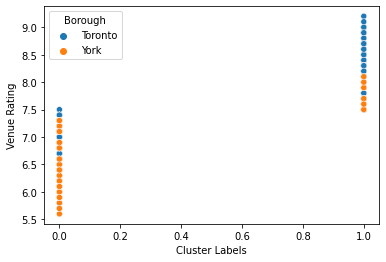

In [32]:
sns.scatterplot(data = data_clustered, x = 'Cluster Labels', y='Venue Rating', hue = 'Borough' )

### In next map, restaurants of Toronto (blue perimeter) and York (perimeter) are marked with green and red fills. Green corresponds to group with rating greater than 7.5 and red fill to restaurants with rating less than 7.5. We can see that most approved restaurants are in Toronto.

In [33]:
map_ty2 = folium.Map(location=[latitude, longitude], zoom_start=12)

addMakersFilled(data_clustered[data_clustered['Borough']=='Toronto'],map_ty2,'blue')
addMakersFilled(data_clustered[data_clustered['Borough']=='York'],map_ty2,'orange')
map_ty2

# 4. Results and Discussion

Results obtained in the analysis, following the methodology, demonstrate that most venues are in Toronto region, which give us an idea of than we will hope about the rating of restaurants between York and Toronto. In this case, we can think that the rating average could to be a little more high than the York restaurants, because will have more people in Toronto who can put a rating, and at same time, the rating will be more trustworthy.

In below cells, we can see clearly that Toronto has 266 approved restaurants, that is the venues count in that region. And, in the York side, we have only 10 restaurants to review. Toronto has the advantage. Also, we have the restaurants mean rating of each region, where Toronto has 8.09 and York 7.74 points. Difference is not significantly, but Toronto's mean rating is more trustworthy because it has the support of more consumers.


In [34]:
data_clustered[data_clustered['Cluster Labels'] == 1][['Borough','Cluster Labels']].groupby('Borough').count()

,Cluster Labels
Borough,
Toronto,266
York,10


In [35]:
data_clustered[data_clustered['Cluster Labels'] == 1][['Borough','Venue Rating']].groupby('Borough').mean()

,Venue Rating
Borough,
Toronto,8.08985
York,7.74000


# 5. Conclusion

If you need to choose a Borough to live, Toronto o York, maybe Toronto is the best option for you because you can find the best and most varied restaurants in the region. People say through their ratings that in Toronto are the best restaurants that you can find in that region.